# **Assignment 1 For Clustering Data Analytics**
<hr>

**Submitted by:** Jude M. Ando & Niles Vincent Gabrielle Rondez <br>
**Course & Year:** BSCS - 2 <br>
**Schedule:** M W 10:30 AM - 12:00 PM <br>
<hr>

## Instruction

@all 
Assignment 1 for Clustering:
New and novel methods in Machine Learning are made either by borrowing formulas and concepts from other scientific fields and redefining it based on new sets of assumptions, or by adding an extra step to an already existing framework of methodology.

In this exercise (Assignment 1 of the Clustering Topic), we will try to develop a novel method of Target Trial Emulation by integrating concepts of Clustering into the already existing framework. Target Trial Emulation is a new methodological framework in epidemiology which tries to account for the biases in old and traditional designs.

These are the instructions:
1. Look at this website: https://rpubs.com/alanyang0924/TTE
2. Extract the dummy data in the package and save it as "data_censored.csv"
2. Convert the R codes into Python Codes (use Jupyter Notebook), replicate the results using your python code.
3. Create another copy of your Python Codes, name it TTE-v2 (use Jupyter Notebook).
4. Using TTE-v2, think of a creative way on where you would integrate a clustering mechanism, understand each step carefully and decide at which step a clustering method can be implemented. Generate insights from your results.
5. Do this by pair, preferably your thesis partner.
6. Push to your github repository.
7. Deadline is 2 weeks from today: February 28, 2025 at 11:59 pm.

HINT: For those who dont have a thesis topic yet, you can actually develop a thesis topic out of this assignment.
<hr>

## Introduction


## 1. Setup

In [126]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

trial_pp_dir = "trial_pp"
trial_itt_dir = "trial_itt"

os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

## 2. Data Preparation

In [134]:
# Load dataset
data_censored = pd.read_csv("data_censored.csv")

# Add missing columns to avoid KeyError in Step 5
data_censored["assigned_treatment"] = data_censored["treatment"]  # Placeholder for treatment assignment
data_censored["followup_time"] = data_censored["period"]  # Initialize follow-up time

print(data_censored.head())


   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  assigned_treatment  followup_time  
0         0         1                   1              0  
1         0         0                   1              1  
2         0         0                   1              2  
3         0         0                   1              3  
4         0         0                   1              4  


## 3. Weight Models and Censoring

### 3.1 Censoring Due to Treatment Switching

In [135]:
# Logistic Regression for treatment switching
switch_model = LogisticRegression()
X_switch = data_censored[["age", "x1", "x3"]]
y_switch = data_censored["treatment"]

switch_model.fit(X_switch, y_switch)
data_censored["switch_weight"] = switch_model.predict_proba(X_switch)[:, 1]

### 3.2 Other Informative Censoring

In [136]:
censor_model = LogisticRegression()
X_censor = data_censored[["x2", "x1"]]
y_censor = 1 - data_censored["censored"]

censor_model.fit(X_censor, y_censor)
data_censored["censor_weight"] = censor_model.predict_proba(X_censor)[:, 1]

## 4. Calculate Weights

In [137]:
data_censored["final_weight"] = data_censored["switch_weight"] * data_censored["censor_weight"]
print(data_censored[["id", "final_weight"]].head())

   id  final_weight
0   1      0.579469
1   1      0.591720
2   1      0.506469
3   1      0.486856
4   1      0.559652


## 5. Specify Outcome Model

In [138]:
X_outcome = sm.add_constant(data_censored[["assigned_treatment", "x2", "followup_time"]])
y_outcome = data_censored["outcome"]

outcome_model = sm.Logit(y_outcome, X_outcome).fit()
print(outcome_model.summary())

Optimization terminated successfully.
         Current function value: 0.076672
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  725
Model:                          Logit   Df Residuals:                      721
Method:                           MLE   Df Model:                            3
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.02457
Time:                        19:13:41   Log-Likelihood:                -55.587
converged:                       True   LL-Null:                       -56.987
Covariance Type:            nonrobust   LLR p-value:                    0.4235
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.5845      0.520     -6.889      0.000      -4.604      -2.565
assig

## 6. Expand Trials

In [139]:
def expand_trials(data):
    expanded_data = data.copy()
    expanded_data["trial_period"] = expanded_data["period"]
    expanded_data["followup_time"] = expanded_data["period"] + 1
    return expanded_data

trial_pp_expanded = expand_trials(data_censored)
trial_itt_expanded = expand_trials(data_censored)

print(trial_itt_expanded.head())

   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  assigned_treatment  followup_time  switch_weight  \
0         0         1                   1              1       0.635527   
1         0         0                   1              2       0.625536   
2         0         0                   1              3       0.550437   
3         0         0                   1              4       0.539801   
4         0         0                   1              5       0.594942   

   censor_weight  final_weight  trial_period  
0       0.911793     

### 6.1 Create Sequence of Trials Data

In [141]:
def create_sequence_of_trials(data):
    expanded_trials = []
    
    for _, row in data.iterrows():
        period_start = int(row["period"])  # Ensure it's an integer
        period_end = period_start + 5  # Expanding up to 5 periods ahead
        
        for t in range(period_start, period_end):
            new_row = row.copy()
            new_row["trial_period"] = t
            new_row["followup_time"] = t - period_start
            expanded_trials.append(new_row)
    
    return pd.DataFrame(expanded_trials)

# Apply to expanded data
trial_pp_seq = create_sequence_of_trials(trial_pp_expanded)
trial_itt_seq = create_sequence_of_trials(trial_itt_expanded)

print(trial_itt_seq.head())

    id  period  treatment   x1        x2   x3        x4   age     age_s  \
0  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
0  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
0  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
0  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
0  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   

   outcome  censored  eligible  assigned_treatment  followup_time  \
0      0.0       0.0       1.0                 1.0            0.0   
0      0.0       0.0       1.0                 1.0            1.0   
0      0.0       0.0       1.0                 1.0            2.0   
0      0.0       0.0       1.0                 1.0            3.0   
0      0.0       0.0       1.0                 1.0            4.0   

   switch_weight  censor_weight  final_weight  trial_period  
0       0.635527       0.911793      0.579469           0.0  
0       0.

## 7. Load or Sample From Expanded Data

In [142]:
sample_size = int(len(trial_itt_expanded) * 0.5)  # 50% control group
trial_itt_sampled = trial_itt_expanded.sample(sample_size, random_state=1234)
print(trial_itt_sampled.head())

     id  period  treatment  x1        x2  x3        x4  age     age_s  \
21    4       2          0   0 -1.025120   1 -1.613258   31 -0.333333   
588  79       1          1   0  0.608054   0 -0.221670   39  0.333333   
271  39       9          1   0 -1.234967   1  0.189371   50  1.250000   
519  69       0          1   0  1.103744   1  0.338365   46  0.916667   
489  60       4          1   1 -0.572508   1  0.237703   44  0.750000   

     outcome  censored  eligible  assigned_treatment  followup_time  \
21         0         0         1                   0              3   
588        0         0         0                   1              2   
271        0         0         0                   1             10   
519        0         1         1                   1              1   
489        0         0         0                   1              5   

     switch_weight  censor_weight  final_weight  trial_period  
21        0.615590       0.936674      0.576607             2  
588   

## 8. Fit Marginal Structural Model

In [143]:
def winsorize_weights(weights):
    q99 = np.percentile(weights, 99)
    return np.minimum(weights, q99)

trial_itt_sampled["adjusted_weight"] = winsorize_weights(trial_itt_sampled["final_weight"])

X_msm = sm.add_constant(trial_itt_sampled[["assigned_treatment", "x2", "followup_time"]])
y_msm = trial_itt_sampled["outcome"]

msm_model = sm.Logit(y_msm, X_msm, weights=trial_itt_sampled["adjusted_weight"]).fit()
print(msm_model.summary())

Optimization terminated successfully.
         Current function value: 0.111899
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  362
Model:                          Logit   Df Residuals:                      358
Method:                           MLE   Df Model:                            3
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.03867
Time:                        19:14:34   Log-Likelihood:                -40.507
converged:                       True   LL-Null:                       -42.137
Covariance Type:            nonrobust   LLR p-value:                    0.3534
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.1434      0.665     -4.727      0.000      -4.447      -1.840
assig

C:\Users\andoj\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
C:\Users\andoj\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


## 9. Inference

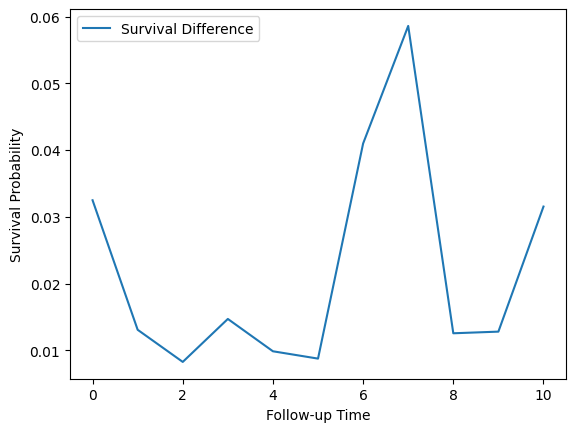

In [147]:
import matplotlib.pyplot as plt

followup_times = np.arange(0, 11)
survival_probs = msm_model.predict(sm.add_constant(trial_itt_sampled[["assigned_treatment", "x2", "followup_time"]]))

plt.plot(followup_times, survival_probs[:len(followup_times)], label="Survival Difference")
plt.xlabel("Follow-up Time")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()